<a href="https://colab.research.google.com/github/pabloalima81/tcc2/blob/main/basico_cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import zipfile
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
import seaborn as sns
import spacy as sp
import string
import random
import matplotlib.pyplot as plt
import nltk
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import datasets
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
%tensorflow_version 2.x
import tensorflow as tf

colunas = ['classe', 'noticias']

data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/cfn/Data/pre-processed.csv', header = None,
                         names = colunas, engine = 'python', encoding = 'utf-8')

noticias = data.iloc[:, 1].values

classes = data.iloc[:, 0].values

classes[classes == 'true'] = 1
classes[classes == 'fake'] = 0

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(noticias, target_vocab_size=70000)

noticias = [tokenizer.encode(sentence) for sentence in noticias]

max_len = max([len(sentence) for sentence in noticias])

noticias = tf.keras.preprocessing.sequence.pad_sequences(noticias, 
                                                         value = 0, 
                                                         padding = 'post',
                                                         maxlen=max_len)

In [ ]:
##Parametros
vocab_size = tokenizer.vocab_size # vocabulário. Altura da matriz de embeddings. Palavras únicas
emb_dim = 300 # largura da matriz de embeddings 

verbose = 1 #mostra informações enquanto executa
#Tamanho dos filtros
kernel_size1=2
kernel_size2=3
kernel_size3=4
loss='binary_crossentropy' #Função de perda
validation_split = 0.2 #percentual de validação durante treinamento
activation='relu' #Função de ativação na camada de convolução
activation_dense='relu' #Função de ativação na camada densa
activation_exit='sigmoid' #Função de ativação para saída 
dropout_rate = 0.2 # Percentual de inativação dos neurônios da camada densa. Evita overfitting
nb_epochs = 100 # épocas de treinamento

nb_filters = 50 # Número de filtros por região
ffn_units = 152 # Número de neurônios na camada escondida (densa)
batch_size_train = 120 # De quanto em quanto registro se atualiza os pesos. Tamanho da amostra de atualização no treino
batch_size_val = 24 # De quanto em quanto registro se atualiza os pesos. Tamanho da amostra de atualização na validação

In [ ]:
class DCNN(tf.keras.Model):
  
  #0 Construtor da classe com passagem de parâmetros
  def __init__(self,
               vocab_size=vocab_size, #Tamanho do vocabulário
               emb_dim=emb_dim, # Tamanho da matriz de embbedings
               nb_filters=nb_filters, #Número de filtros por região
               ffn_units=ffn_units, #Feedforward - Número de neuronios da Rede neural densa
               dropout_rate=dropout_rate, #Zera percentual de neurônios para evitar overfetting
               training=True,
               name="dcnn"):
    super(DCNN, self).__init__(name=name)
    #1 Gera matriz de palavras
    self.embedding = layers.Embedding(vocab_size, emb_dim)
    #2 Gera os filtros de tamanho 2
    self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=kernel_size1, padding='same', activation=activation)
    #2.1 Gera os filtros de tamanho 3
    self.trigram = layers.Conv1D(filters=nb_filters, kernel_size=kernel_size2, padding='same', activation=activation)
    #2.2 Gera os filtros de tamanho 4
    self.fourgram = layers.Conv1D(filters=nb_filters, kernel_size=kernel_size2, padding='same', activation=activation)
    #3 Etapa de maxpooling
    self.pool = layers.GlobalMaxPool1D()

    #4 Rede neural densa com ffn_unit definindo o numero de neuronios e função de ativação relu
    self.dense_1 = layers.Dense(units = ffn_units, activation = activation_dense)
    #4.1 Passagem do parametro de dropout para evitar overfetting
    self.dropout = layers.Dropout(rate = dropout_rate)
    #4.2 Define a camada de saída com 1 bit e função de ativação sigmoid
    self.last_dense = layers.Dense(units = 1, activation = activation_exit)

  #Função que faz a "conexão" dos objetos da rede
  def call(self, inputs, training):
    #Matriz de palavras recebe o texto
    x = self.embedding(inputs)
    #Filtros da região 3 recebem a matriz de palavras
    x_1 = self.bigram(x)
    #Executa o maxpooling no bigram
    x_1 = self.pool(x_1)
    #Filtros da região 2 recebem a matriz de palavras
    x_2 = self.trigram(x)
    #Executa o maxpooling no trigram
    x_2 = self.pool(x_2)
    #Filtros da região 2 recebem a matriz de palavras
    x_3 = self.fourgram(x)
    #Executa o maxpooling no fourgram
    x_3 = self.pool(x_3)
    #Faz a concatenação após o max pooling
    merged = tf.concat([x_1, x_2, x_3], axis = -1) # Return (batch_size, número de camadas (3) * nb_filters)
    #A camada primeira camada densa recebe o vetor concatenado
    merged = self.dense_1(merged)
    #Zera uma porção dos neurônios
    merged = self.dropout(merged, training)
    #Liga a camada de dropout a camada de saída
    output = self.last_dense(merged)
  
    return output

In [ ]:
  noticias = noticias.astype(np.int64)
  classes = classes.astype(np.int64)
  noticias.shape
  noticias.shape[0]
  b = np.zeros(shape=(noticias.shape[0], 1))

  print('Filtros por região: ',nb_filters)
  print('Neuronios na camada densa: ',ffn_units)
  print('Percentural de neuronios inativados:' ,dropout_rate)
  print('Tamanho do lote no treino:', batch_size_train)
  print('Tamanho do lote na validação:', batch_size_val)
  print('Número de épocas:', nb_epochs)
  print('Ativação:', activation)

  kfold = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 10)
  resultados = []
  matrizes = []
  history = []
  validacao=[]
  for indice_treinamento, indice_teste in kfold.split(noticias,
                                                      np.zeros(shape=(noticias.shape[0], 1))):
      print("Kfold: ", indice_treinamento[kfold.n_splits])
      Dcnn = DCNN(vocab_size=vocab_size, emb_dim=emb_dim, nb_filters=nb_filters,
              ffn_units=ffn_units, dropout_rate=dropout_rate)
      Dcnn.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
      historico = Dcnn.fit(noticias[indice_treinamento], classes[indice_treinamento],
                          batch_size = batch_size_train,
                          epochs = nb_epochs,
                          verbose = 1,
                          validation_split = validation_split)
      precisao = Dcnn.evaluate(noticias[indice_teste], classes[indice_teste], batch_size = batch_size_val)
      previsoes = Dcnn.predict(noticias[indice_teste])
      previsoes = (previsoes > 0.5)
      matrizes.append(confusion_matrix(classes[indice_teste], previsoes))
      resultados.append(precisao)
      history.append(historico)
      precisao.append(validacao)
  print(matrizes)
  print("Treinamento concluído!")

Filtros por região:  50
Neuronios na camada densa:  152
Percentural de neuronios inativados: 0.2
Tamanho do lote no treino: 120
Tamanho do lote na validação: 24
Número de épocas: 100
Ativação: relu
Kfold:  5
Epoch 1/100
36/36 [==============================] - 57s 700ms/step - loss: 0.5255 - accuracy: 0.7676 - val_loss: 0.2642 - val_accuracy: 0.9176
Epoch 2/100
36/36 [==============================] - 25s 696ms/step - loss: 0.1033 - accuracy: 0.9708 - val_loss: 0.1092 - val_accuracy: 0.9611
Epoch 3/100
36/36 [==============================] - 25s 696ms/step - loss: 0.0218 - accuracy: 0.9954 - val_loss: 0.1377 - val_accuracy: 0.9491
Epoch 4/100
36/36 [==============================] - 24s 668ms/step - loss: 0.0054 - accuracy: 0.9998 - val_loss: 0.1432 - val_accuracy: 0.9472
Epoch 5/100
36/36 [==============================] - 24s 667ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.1442 - val_accuracy: 0.9528
Epoch 6/100
36/36 [==============================] - 25s 697ms/step - lo

#Análise dos Dados

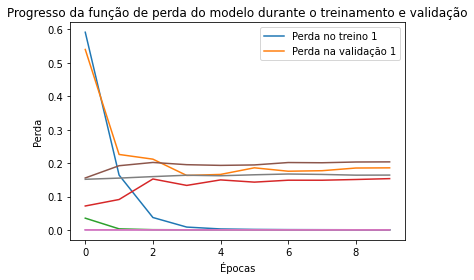

In [ ]:
plt.plot(history[0].history['loss'])
plt.plot(history[0].history['val_loss'])
plt.plot(history[1].history['loss'])
plt.plot(history[1].history['val_loss'])
plt.plot(history[2].history['loss'])
plt.plot(history[2].history['val_loss'])
plt.plot(history[3].history['loss'])
plt.plot(history[3].history['val_loss'])
plt.title('Progresso da função de perda do modelo durante o treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend(['Perda no treino 1', 'Perda na validação 1'])

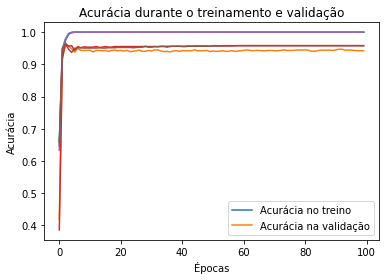

In [ ]:
plt.plot(history[0].history['accuracy'])
plt.plot(history[0].history['val_accuracy'])
plt.plot(history[1].history['accuracy'])
plt.plot(history[1].history['val_accuracy'])
plt.plot(history[2].history['accuracy'])
plt.plot(history[2].history['val_accuracy'])
plt.title('Acurácia durante o treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend(['Acurácia no treino', 'Acurácia na validação'])

In [ ]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(classes[indice_teste], previsoes, pos_label=2)
metrics.auc(fpr, tpr)
metrics.plot_roc_curve(fpr, tpr, thresholds)  
plot.show()

In [ ]:
matriz = [[9,1],[3,7]]
print(matriz)

[[9, 1], [3, 7]]


Text(0.5, 1.0, 'Matriz de confusão do classificador')

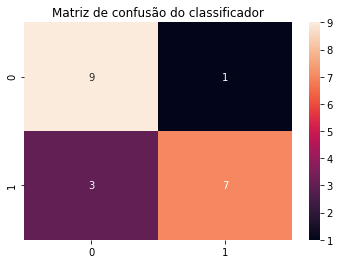

In [ ]:
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
import seaborn as sns
import spacy as sp
import string
import random
import matplotlib.pyplot as plt
import nltk
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import datasets
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
%tensorflow_version 2.x
import tensorflow as tf
sns.heatmap(matriz, annot=True)
plt.title('Matriz de confusão do classificador')

#Novas Previsões

In [ ]:
#Remove caracteres especiais

def clean_text(text):
  text = BeautifulSoup(text, 'lxml').get_text()
  text = re.sub(r"@[A-Za-z0-9]+", ' ', text)
  text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
  text = re.sub(r"[^a-zA-Z.!?]", ' ', text)
  text = re.sub(r" +", ' ', text)
  return text

In [ ]:
#remove Stopwords

!python -m spacy download pt
nlp = sp.load('pt')
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')

def clean_sw(text):
  text = text.lower()
  document = nlp(text)

  words = []
  for token in document:
    words.append(token.text)

  words = [word for word in words if word not in stopwords and word not in string.punctuation]
  words = ' '.join([str(element) for element in words])

  return text

In [ ]:
text = 'alcool em gel pode ser feito em casa com apenas dois ingredientes'
text = clean_text(clean_sw(text))
print(text)
text = tokenizer.encode(text)

alcool em gel pode ser feito em casa com apenas dois ingredientes


In [ ]:
pred= Dcnn(np.array([text]), training=False).numpy()
pred = (pred >0.5)
print(pred)

[[False]]
